# Input DEM of Pommeroye

In [1]:
from osgeo import gdal
from scipy.interpolate import RegularGridInterpolator

import math
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import verde as vd

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

In [2]:
adffile = '/work/armitagj/Documents/MPH03001-benchmark/data/Pommeroye/data-start-stage/SIG/Canche/Pommeroye/dem_pom/w001001.adf'

In [3]:
rio_array = rio.open(adffile)  # us rasterio to read the point data file

In [4]:
data_array = rio_array.read(1)  # assume elevation is in the first band
print(data_array.min())

-3.4028235e+38


In [5]:
data_array[data_array < 0] = np.nan

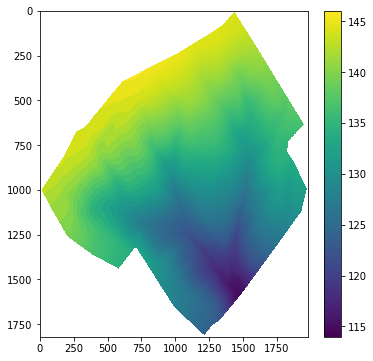

In [6]:
plt.figure(figsize=[6, 6])
plt.imshow(data_array, aspect='auto')
plt.colorbar()
plt.savefig('catchment_array.png')
plt.show()

### The catchment outlet could be rotated to align with the right boundary

I'll load in the asc DEM of the Pommeroye that Nolwen made using QGIS as this has the correct dimensions of each cell. 

In [7]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/input_data/MNT_Pommeroye.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
Z = np.flipud(data_array)  # need to flip the array up-down
X,Y = np.meshgrid(xcorner, ycorner)

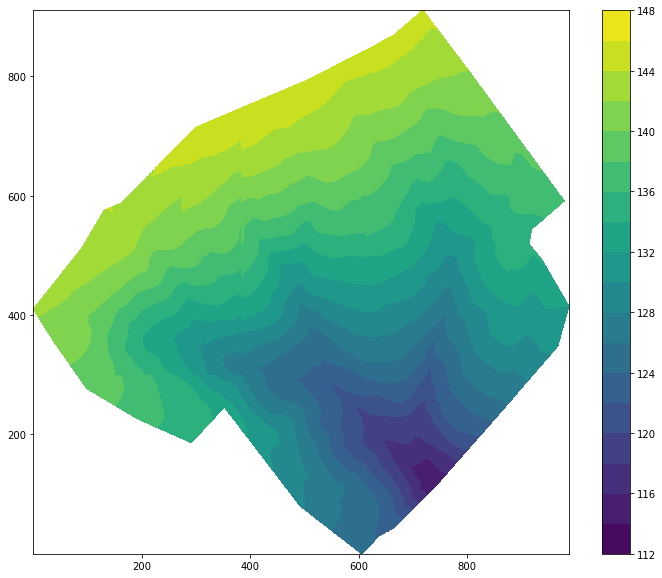

In [8]:
plt.figure(figsize=[12, 10])
plt.contourf(X, Y, Z, 20)
plt.colorbar()
plt.show()

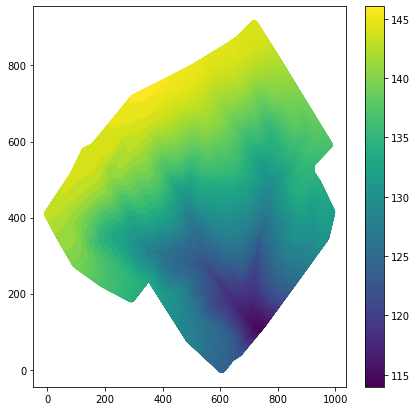

In [9]:
plt.figure(figsize=[7, 7])
plt.scatter(X, Y, c=Z)
plt.colorbar()
plt.show()

There are loads of points here, so first I will reduce the resolution to something a bit more manageable 

In [10]:
print(dXY)

0.5


That's every 50 cm! So I'll reduce the DEM to 10 m cells.

In [11]:
outdxy = 10
ny, nx = np.shape(Z)  # number of cells in x and y

in_array = Z.copy()
in_array[in_array <= 0] = np.nan
x = np.linspace(0, dXY * nx, nx)
y = np.linspace(0, dXY * ny, ny)

ny = np.int((dXY * ny) / outdxy) # number of cells in new output DEM
nx = np.int((dXY * nx) / outdxy)
outx = np.linspace(0, outdxy * nx, nx)
outy = np.linspace(0, outdxy * ny, ny)
outX, outY = np.meshgrid(outx, outy)  # new grid of x and y coordinates
print('output cell size is {} m'.format(outX[0, 1] - outX[0, 0]))

resample = RegularGridInterpolator((y, x), in_array)  # use the scipy RegularGridInterpolator to resample the DEM
pts = np.stack((np.ravel(outY), np.ravel(outX)), axis=-1)  # points to resample to
data_vector = resample(pts)  # output DEM vector
data_array = data_vector.reshape(np.int(ny), np.int(nx))  # ouput DEM array

output cell size is 10.103092783505154 m


/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


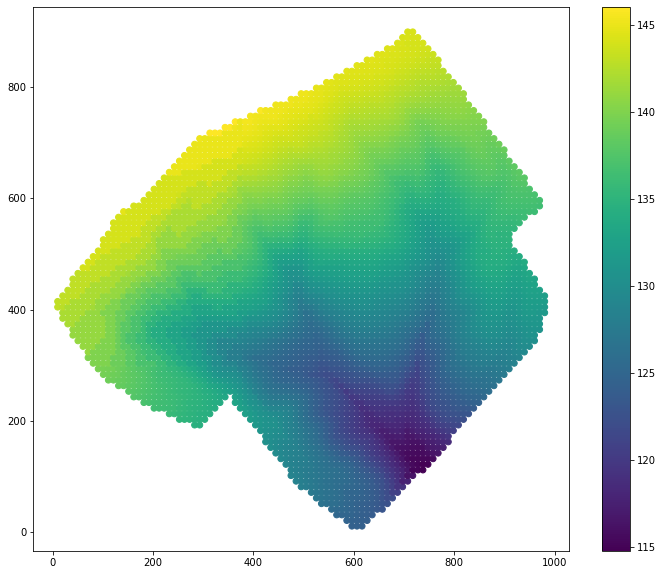

In [12]:
plt.figure(figsize=[12, 10])
plt.scatter(outX, outY, c=data_array)
plt.colorbar()
plt.show()

Lets do some math:
$$x_{new} = x cos(\alpha) - y sin(\alpha)$$
$$y_{new} = x sin(\alpha) + y cos(\alpha)$$
where $\alpha$ is the angle of rotation. But first I need to put the origin at the centre of the DEM.

In [13]:
X = outX.copy()
Y = outY.copy()
Z = data_array.copy()

# Shift the x and y coordinates so the origin is in the middle
X = X - X.min() - 0.5*X.max()
Y = Y - Y.min() - 0.5*Y.max()

In [14]:
alpha = np.pi * 45/180  # 45°

Xnew = math.cos(alpha) * X - math.sin(alpha) * Y
Ynew = math.sin(alpha) * X + math.cos(alpha) * Y

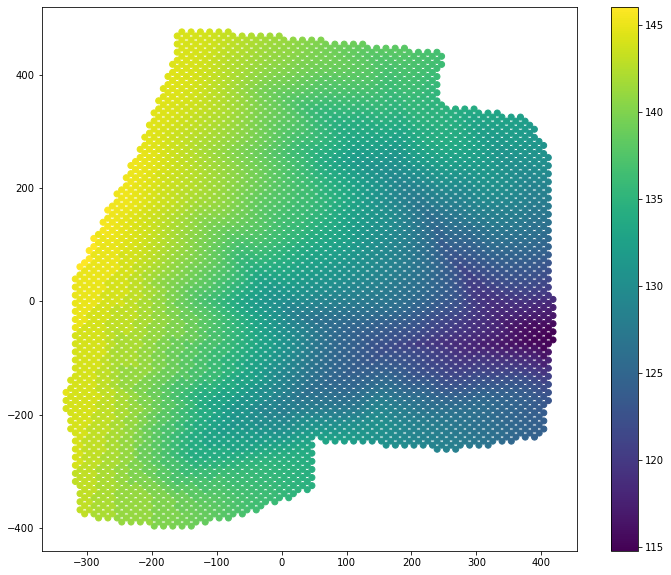

In [15]:
plt.figure(figsize=[12, 10])
plt.scatter(Xnew, Ynew, c=Z)
plt.colorbar()
plt.show()

Then we can shift the origin to the right by 350 m and upwards by 410 m

In [16]:
Xnew = Xnew + 350
Ynew = Ynew + 410

Now interpolate the points onto a regular grid. To do this I will use the library [`verde`](https://www.fatiando.org/verde/latest/index.html) to fit a 2D spline function to the data and create a mask 

In [17]:
xcoord_all = Xnew.flatten()
ycoord_all = Ynew.flatten()
elevation = Z.flatten()

xcoord = xcoord_all[~np.isnan(elevation)]
ycoord = ycoord_all[~np.isnan(elevation)]
elevation = elevation[~np.isnan(elevation)]

coord = [xcoord, ycoord]

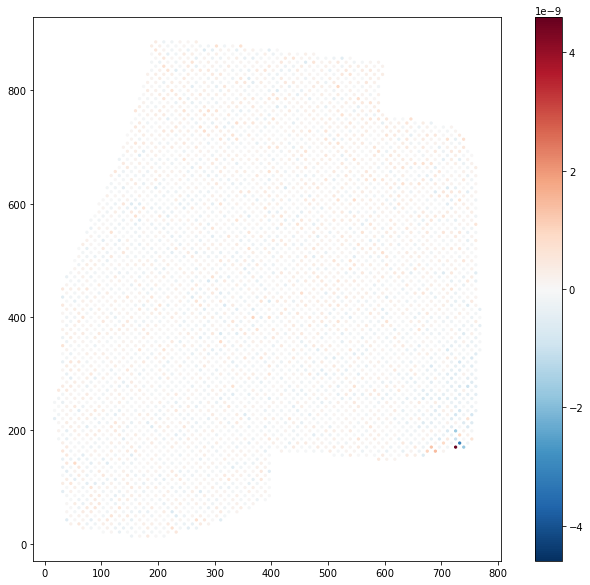

In [18]:
spline = vd.Spline()
spline.fit(coord, elevation)
predicted = spline.predict(coord)
residuals = elevation - predicted
scale = vd.maxabs(residuals)

plt.figure(figsize=[12,10])
plt.scatter(coord[0], coord[1], c=residuals, s=5, cmap='RdBu_r', vmin=-scale, vmax=scale)
plt.axis('scaled')
plt.colorbar()
plt.show()

Above I used a spline fit to the the input points to get a model for the data. I then tested the model against the input data and the difference (residual) is very small. Next I want to create a mask do only have the points inside the catchment and finally predict the elevation on a new regular grid. 

In [19]:
region = vd.get_region((xcoord, ycoord))  # get the region of interest from the input coordinates

# Generate the coordinates for a regular grid mask
spacing = 10
coordinates = vd.grid_coordinates(region, spacing=spacing)

elevation_new = spline.predict(coordinates)  # predict the elevation on the regular grid
mask = vd.distance_mask((xcoord, ycoord), maxdist=10, coordinates=coordinates)  # create the mask
elevation_new[~mask] = np.nan  # remove points outside the mask

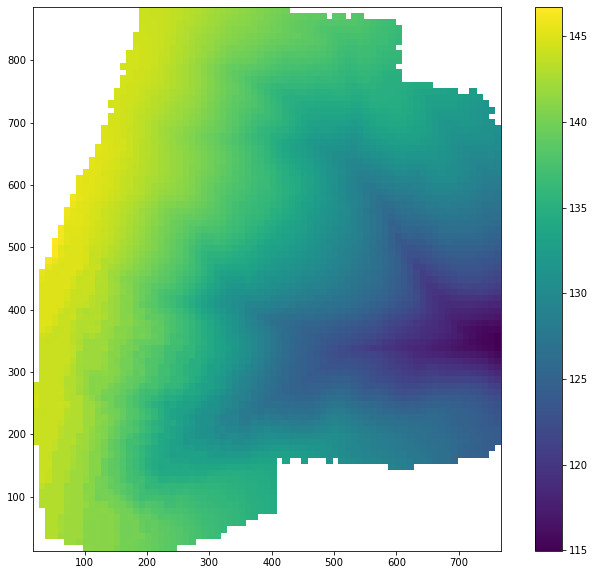

In [20]:
plt.figure(figsize=[12,10])
plt.pcolormesh(*coordinates, elevation_new)
plt.axis('scaled')
plt.colorbar()
plt.show()

Finally export to a new asc file

In [21]:
ascfile = 'rotated_MNT.asc'

f = open(ascfile, 'w')
f.write('ncols         {}\n'.format(np.shape(elevation_new)[1]))
f.write('nrows         {}\n'.format(np.shape(elevation_new)[0]))
f.write('xllcorner     {}\n'.format(np.min(coordinates[0])))
f.write('yllcorner     {}\n'.format(np.min(coordinates[1])))
f.write('cellsize      {}\n'.format(spacing))
f.write('NODATA_value  -9999\n')

pix = '{0} '
for i in range(np.shape(elevation_new)[0]):
    for j in range(np.shape(elevation_new)[1]):
        if np.isnan(elevation_new[i, j]) == True:
            f.write(pix.format(np.int(-9999)))  # need to replace nan with -9999
        else:
            f.write(pix.format(elevation_new[i, j]))
    f.write("\n")
f.close()

And then check that it is all good.

In [22]:
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
Z = data_array
X,Y = np.meshgrid(xcorner, ycorner)

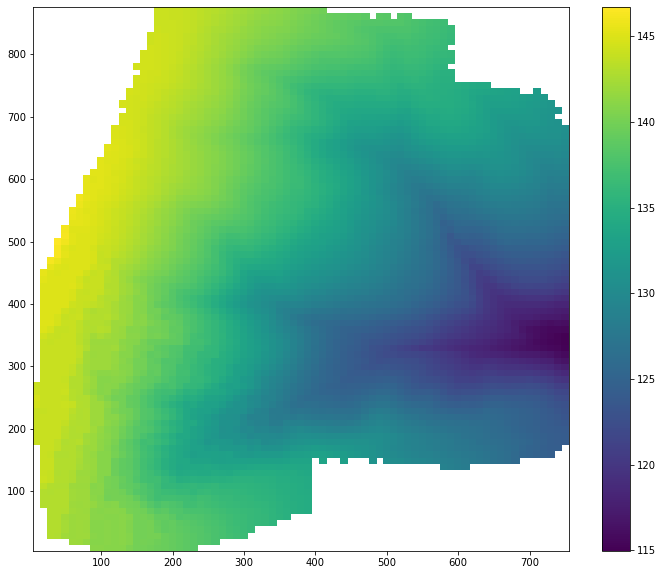

In [23]:
plt.figure(figsize=[12,10])
plt.pcolormesh(X, Y, Z)
plt.colorbar()
plt.show()